In [1]:
from requests import get
from requests.exceptions import RequestException
from contextlib import closing
from bs4 import BeautifulSoup
import re
import csv

# Setup Parsing Functions

In [2]:
def simple_get(url):
    """
    Attempts to get the content at `url` by making an HTTP GET request.
    If the content-type of response is some kind of HTML/XML, return the
    text content, otherwise return None.
    """
    try:
        with closing(get(url, stream=True)) as resp:
            if is_good_response(resp):
                return resp.content
            else:
                print('error')
                return None

    except RequestException as e:
        log_error('Error during requests to {0} : {1}'.format(url, str(e)))
        return None

In [3]:
def is_good_response(resp):
    """
    Returns True if the response seems to be HTML, False otherwise.
    """
    content_type = resp.headers['Content-Type'].lower()
    return (resp.status_code == 200 
            and content_type is not None 
            and content_type.find('html') > -1)

In [4]:
def get_data(url):
    raw_html = simple_get(url)

    soup = BeautifulSoup(raw_html, 'html.parser')
    url_parts = url.split("/")
    strain_id = url_parts[-2]+":"+url_parts[-1]
    name = ''
    try:
        name = " ".join(soup.title.getText().split(" ")[:-5])
    except:
        print('error in getting name')
  #  print(name)

    desc_text = ''
    try:
        desc = soup.find('div', class_='description')
        desc_text = desc.p.getText()
  #      print(desc.p.getText())
    except:
        print('',end='')

   # print()
   # print('GROW INFO:')

    grow_info_str = ''
    try:
        grow_info = soup.find_all('div', class_=['growInfoRow','growInfoRow desktopYield'])
        for grow in grow_info:
            val = grow.find(lambda tag: tag.name == 'div' and 
                                tag.get('class') and tag.get('class') == ['selected'] )
            label = grow.find(lambda tag: tag.name == 'div' and
                                tag.get('class') and tag.get('class') == ['strain__data'])
            label = label.text.strip()
            val = val.text.strip()

        #    print(label + ':' + val)
            grow_info_str += label + ':' + val + ','
      #  print()
    except:
        print('',end='')
                        

    effects = ''
    medical = ''
    negatives = ''

    try:
        categories = soup.find_all(lambda tag: tag.name == 'div' and
                                    tag.get('class') == ['m-histogram'])
        

        for cat in categories:
            category = cat['ng-show'].split('===')[1][1:-1]
          #  print(category)

            hists = cat.find_all(lambda tag: tag.name == 'div' and 
                                            tag.get('class') == ['m-histogram-item-wrapper'])
            for item in hists:
                label = item.find('div', class_='m-attr-label copy--sm').string
                val = item.find('div', class_='m-attr-bar')['style'].split(':')[1][:-1]
                val = round(float(val),2)
                if category == 'Effects':
                    effects += label + ':' + str(val) + ','
                elif category == 'Medical':
                    medical += label + ':' + str(val) + ','
                elif category == 'Negatives':
                    negatives += label + ':' + str(val) + ','
         #       print(label + ':sdf ' + str(val))
         #   print()

            
            
    except:
        print('',end='')

    all_flavors = 'Ammonia Apple Apricot Berry Blue Cheese Blueberry Butter Cheese Chemical Chestnut Citrus Coffee Diesel Earthy Flowery Grape Grapefruit Honey Lavender Lemon Lime Mango Menthol Mint Nutty Orange Peach Pear Pepper Pine Pineapple Plum Pungent Rose Sage Skunk Spicy/Herbal Strawberry Sweet Tar Tea Tobacco Tree Fruit Tropical Vanilla Violet Woody'
    
    flavor_str = ''
    try:
        flavors = soup.find_all(lambda tag: tag.name == 'li' and
                                    tag.get('class') and 
                                        tag.get('class')[0].find("grid-1-3 grid-xs-1-3 copy--centered colored-background") and
                                            tag.get('title') and tag.get('title').find(all_flavors))
      #  print('FLAVORS:')
        if flavors:
            for flavor in flavors:
            #    print(flavor['title'])
                flavor_str += flavor['title'] + ','
     #   print()
    except:
        print('',end='')
   # print('PARENTS:')

    parents_str = ''
    try:
        lineage = soup.find('div', class_='strain__lineage strain__dataTab')
        if lineage:
            parent = lineage.find_all(lambda tag: tag.name == 'a' and tag.get('href'))
            if parent:
                for p in parent:
                    par = p['href'].split('/')
                #    print('type: ' + par[len(par) - 2] + ' strain: ' + par[len(par) - 1])
                    parents_str += par[len(par) - 2] + ':' + par[len(par) - 1] + ','
    except:
        print('',end='')

    rate_str = ''
    try:
        rate = soup.find(lambda tag: tag.name == 'div' and 
                            tag.get('itemprop') and tag.get('itemprop') == 'aggregateRating')
        avg_rating = rate.find(lambda tag: tag.name == 'span' and tag.get('star-rating'))
        rate_str = avg_rating['star-rating']
    except:
        print('',end='')
    
    num_rate = ''
    try:
        num_ratings = rate.find(lambda tag: tag.name == 'span' and tag.get('itemprop') and
                            tag.get('itemprop') == 'reviewCount')
        num_rate = num_ratings.text
    except:
        print('',end='')
  #  print()

    
  #  if avg_rating and avg_rating['star-rating']:
    #    print(avg_rating['star-rating'])
   # if num_ratings and num_ratings.text:
     #   print(num_ratings.text)
    return {'strain_id':strain_id, 'url':url,'name':name,'desc':desc_text,
            'grow_info':grow_info_str,'effects':effects,'medical':medical,'negatives':negatives,
            'flavors':flavor_str,'parents':parents_str,'ratings':rate_str,'num_ratings':num_rate}


## Debug Parsing:

In [5]:
bad_name='sativa:island-maui-haze'
bad_name_parts = bad_name.split(':')
bad_url= 'https://www.leafly.com/%s/%s' % (bad_name_parts[0],bad_name_parts[1])
print(bad_url)
result = get_data(bad_url)
print(result)

https://www.leafly.com/sativa/island-maui-haze
{'strain_id': 'sativa:island-maui-haze', 'url': 'https://www.leafly.com/sativa/island-maui-haze', 'name': 'Island Maui Haze', 'desc': 'Island Maui Haze is a 75/25 sativa-dominant strain with effects that can creep up on you. These dense, forest green buds may not initially attract you based on its strong, ammonia smell; however, this crystal-covered strain is praised for its uplifting, energetic effects that can relieve pain and other symptoms without bringing you down into a lazy state.\xa0', 'grow_info': '', 'effects': 'Relaxed:100.0,Happy:97.62,Talkative:88.1,Euphoric:16.67,Tingly:9.52,', 'medical': 'Stress:100.0,Depression:90.91,Headaches:88.64,Pain:88.64,Inflammation:86.36,', 'negatives': 'Dry Mouth:100.0,Anxious:100.0,Paranoid:50.0,', 'flavors': 'Citrus,Mango,Tropical,', 'parents': '', 'ratings': '4.53333333333333', 'num_ratings': '15'}


# Extract & Parse URLs - Note that the scraping part of this section is commented out so that rerunning everything does not take 90 minutes

In [6]:
# Extracting URLs from Leafly sitemap using BeautifulSoup to parse
soup = BeautifulSoup(open("./LeaflySitemap.xml", "r"), "lxml-xml")
urls  = [a.text for a in (urls.find("loc") for urls in soup.find_all("url")) if a]

# Extracting only strain URLs from the complete list
# Required URLs have format https://www.leafly.com/{sativa|indica|hybrid}/{strain_name}
regexExp = "https?:\/\/(www\.)?(leafly\.com)\/(hybrid|sativa|indica)\/+[^\/]+[-a-zA-Z0-9@:%._\+~#=]$"
regex = re.compile(regexExp)
strain_URLs = list(filter(regex.search, urls))

# Already run - uncomment to rerun
# with open('strains.csv','w') as f:
#     fields = ['strain_id','url','name','desc','grow_info','effects','medical','negatives','flavors','parents','ratings','num_ratings']
#     csvwriter=csv.DictWriter(f, fieldnames=fields)
#     csvwriter.writeheader()

#     i = 0
#     siz = len(strain_URLs)
#     for url in strain_URLs:
#         result = get_data(url)
#         csvwriter.writerow(result)
#         # How far are we:
#         print('\r' + str(100 * i / siz),end='')
#         i+=1

# Data Cleaning
## TODO what do we need from this

In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.read_csv('./strains.csv')

In [9]:
df['num_ratings'].fillna(value=0,inplace=True)
df['ratings'].fillna(value=0,inplace=True)

In [10]:
#new_df.to_csv('./strains_cleaned.csv',index=False)
df.to_csv('./strains_cleaned.csv',index=False)

# Filtering & Reformatting Data

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
plt.rcParams['figure.figsize'] = [12,12]

In [12]:
df.columns

Index(['strain_id', 'url', 'name', 'desc', 'grow_info', 'effects', 'medical',
       'negatives', 'flavors', 'parents', 'ratings', 'num_ratings'],
      dtype='object')

In [13]:
df = pd.read_csv('./strains_cleaned3.csv')
df.head(3)

,strain_id,name,url,desc,parents,Anxious,Aroused,Creative,Energetic,Euphoric,...,Headaches,Fatigue,Eye Pressure,Dizzy,Paranoid,Dry Eyes,Dry Mouth,Headache,ratings,num_ratings
0,hybrid:sweet-nina,Sweet Nina,https://www.leafly.com/hybrid/sweet-nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",100.00,0.0,0.00,0.0,75.0,...,0.0,0.0,0.0,100.00,100.00,5.56,0.0,0.0,3.857143,6.0
1,indica:hawaiian-purple-kush,Hawaiian Purple Kush,https://www.leafly.com/indica/hawaiian-purple-...,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",2.38,0.0,86.87,0.0,0.0,...,0.0,0.0,0.0,2.38,92.86,97.62,100.0,0.0,4.486486,32.0
2,indica:lime-purple-mist,Lime Purple Mist,https://www.leafly.com/indica/lime-purple-mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,100.0,0.0,4.333333,4.0


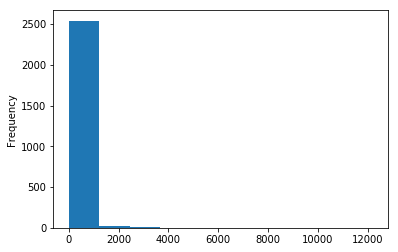

In [14]:
df['num_ratings'].plot.hist(bins=10)

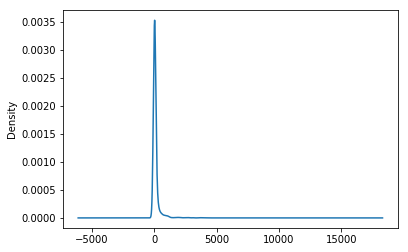

In [15]:
df['num_ratings'].plot.density()

In [16]:
df.shape

(2669, 87)

In [17]:
parents=df['parents'].str.split(',',expand=True).head()
parents

,0,1,2,3,4,5,6,7
0,indica:hindu-kush,,None,None,None,None,None,None
1,sativa:hawaiian,indica:purple-kush,,None,None,None,None,None
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,indica:bloos-kloos,indica:white-rhino,,None,None,None,None,None
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
parents[7].unique()

array([None, nan], dtype=object)

In [19]:
df0=df
df0.shape

(2669, 87)

In [20]:
import json
# Handle name changes that redirect but the backend was never updated
# Note that the second part of the name appears to be unique, but the first part is very important to classification
# The dictionary size could be reduced by adding fallback behaviour to try the other categories if missing
substituition_dict = {'hybrid:girl-scout-cookie':'hybrid:gsc',
                      'hybrid:platinum-girl-scout-cookies':'hybrid:platinum-gsc',
                      'hybrid:platinum-girl-scout-cookie':'hybrid:platinum-gsc',
                      'indica:ogre':'hybrid:ogre', 
                      'hybrid:skywalker-og':'hybrid:mazar-x-blueberry', 
                      'hybrid:hells-angel-og':'hybrid:hells-og',
                      'hybrid:gg-4':'hybrid:original-glue', 
                      'hybrid:gorilla-glue-4':'hybrid:original-glue', 
                      'sativa:north-american':'indica:north-american', 
                      'hybrid:nevilles-haze':'sativa:nevilles-haze', 
                      'sativa:jesus-og':'indica:jesus-og',
                      'hybrid:casey-jones':'sativa:casey-jones', 
                      'hybrid:trinity':'sativa:trinity', 
                      'hybrid:northern-lights--5':'indica:northern-lights--5', 
                      'hybrid:blue-mystic':'indica:blue-mystic', 
                      'indica:nepalese':'sativa:nepalese', 
                      'indica:blackberry':'hybrid:blackberry', 
                      'hybrid:querkle':'indica:querkle', 
                      'sativa:micky-kush':'sativa:mickey-kush', 
                      'indica:29aca226-23ba-4726-a4ab-f3bf68f2a3c4':'indica:dynamite', 
                      'hybrid:sweet-tooth':'indica:sweet-tooth', 
                      'hybrid:tangerine-sunrise':'sativa:tangerine-sunrise', 
                      'hybrid:rockstar-kush':'indica:rockstar-kush',
                      'sativa:rene':'hybrid:rene', 
                      'hybrid:hashplant-haze':'sativa:hashplant-haze', 
                      'hybrid:gorilla-glue-1':'hybrid:sister-glue', 
                      'hybrid:fruity-pebbles':'hybrid:fpog', 
                      'indica:skywalker':'hybrid:mazar-x-blueberry'}

# Uglier but faster
# Especially ugly case - uppercase the first letter before returning via lookup
type_enum=["Sativa","Hybrid","Indica"]
type_cat_enum = {"sativa":0,"hybrid":1,"indica":2}
def category(strain_id):
    strain_type=strain_id.split(':')[0]
    index = type_cat_enum[strain_type]
    return (type_enum[index], index)

effects_enum = ['Anxious', 'Aroused', 'Creative', 'Energetic', 'Euphoric', 'Focused', 'Giggly', 'Happy', 'Hungry', 'Relaxed', 'Sleepy', 'Talkative', 'Tingly', 'Uplifted']
effects_cat_enum = {effects_enum[i]: i for i in range (0, len(effects_enum))}
def category_effect(row):
    categories = {}
    largest = effects_enum[0]
    num = row[effects_enum[0]]
    for effect in effects_enum:
        if row[effect] > num:
            largest = effect
            num = row[effect]
    return (largest,effects_cat_enum[largest])

negs_enum = ['Dizzy', 'Paranoid', 'Anxious', 'Dry Eyes', 'Dry Mouth', 'Headache']
negs_cat_enum = {negs_enum[i]: i for i in range (0, len(negs_enum))}       
def category_neg(row):
    largest = negs_enum[0]
    num = row[negs_enum[0]]
    for effect in negs_enum:
        if row[effect] > num:
            largest = effect
            num = row[effect]
    return (largest, negs_cat_enum[largest])

meds_enum = ['Stress','Inflammation', 'Nausea', 'Pain', 'Depression', 'Insomnia', 'Lack of Appetite','Cramps', 'Seizures', 'Muscle Spasms', 'Headaches', 'Fatigue', 'Eye Pressure']
meds_cat_enum= {meds_enum[i]: i for i in range (0, len(meds_enum)) }
def category_med(row):
    largest = meds_enum[0]
    num = row[meds_enum[0]]
    for med in meds_enum:
        if row[med] > num:
            largest = med
            num = row[med]
    return (largest, meds_cat_enum[largest])

            
flavors_enum = ['Ammonia', 'Apple', 'Apricot', 'Berry', 'Blue Cheese', 'Blueberry', 'Butter',
              'Cheese', 'Chemical', 'Chestnut', 'Citrus', 'Coffee', 'Diesel', 'Earthy', 'Flowery', 
              'Grape', 'Grapefruit', 'Honey', 'Lavender', 'Lemon', 'Lime', 'Mango', 'Menthol', 'Mint',
              'Nutty', 'Orange', 'Peach', 'Pear', 'Pepper', 'Pine', 'Pineapple', 'Plum', 'Pungent', 'Rose',
              'Sage', 'Skunk', 'Spicy/Herbal', 'Strawberry', 'Sweet', 'Tar', 'Tea', 'Tobacco', 'Tree', 'Fruit',
              'Tropical', 'Vanilla', 'Violet', 'Woody']
categories = {}
for i in range (0, len(flavors_enum)):
    categories[flavors_enum[i]] = i
flavors_cat_enum = {flavors_enum[i]: i for i in range (0, len(flavors_enum))}
# Making sure I got this right
print("These two should be the same:")
print(categories)
print(flavors_cat_enum)
def category_flavor(row):
    largest = flavors_enum[0]
    num = row[flavors_enum[0]]
    for flavor in flavors_enum:
        if row[flavor] > 0:
            largest = flavor
            num = row[flavor]
    return (largest, flavors_cat_enum[largest])

parent_ids=set() # All ids that show up in parents, thus we need them even if they don't have children
def precompute_ids(row):
        found_ids.add(row["strain_id"])
        if (row["parents"] and type(row["parents"])==str):
            for p in row["parents"].split(','):
                if not len(p):
                    continue
                elif p in substituition_dict:
                    parent_ids.add(substituition_dict[p])
                else:
                    parent_ids.add(p)
parent_names={}
def lookup_parent_names(row):
    strain_id=row["strain_id"]
    if strain_id in parent_ids:
        parent_names[strain_id]=row["name"]

found_ids=set()
missing_ids=set()
nodes = []
links = []
info = {}
metadata = {}
def calculate(row):
    strain_id = row["strain_id"]
    parent_list = []
    if (row["parents"] and type(row["parents"]) == str):
        for p in row["parents"].split(','):
            if not len(p):
                continue
            elif p in substituition_dict:
                parent = substituition_dict[p]
            elif p not in found_ids:
                missing_ids.add(p)
                print("Strain %s is missing parent %s"%(strain_id,p))
                continue
            else:
                parent = p
            parent_list.append(parent) 
            links.append({ "source": parent, "target": strain_id})
        row["parents"] = parent_list
    if len(parent_list) or strain_id in parent_ids:
        # TODO what if they are all 0? defaults to first?
        # TODO do we end up with only one of several flavors? are they ordered? etc
        cat_type=category(strain_id)
        cat_effect=category_effect(row)
        cat_neg=category_neg(row)
        cat_med=category_med(row)
        cat_flavor=category_flavor(row)
        nodes.append({"strain_id": strain_id, 
                      "name": row["name"], 
                      "cat_type":cat_type[1],
                      "cat_effect":cat_effect[1],
                      "cat_neg":cat_neg[1],
                      "cat_med":cat_med[1],
                      "cat_flavor": cat_flavor[1]})
        # Format for card info entries
        # Yes, sorry, you have to deal with null values in desc, rating, & rating count
        info[strain_id]={'name':row['name'],
                         'url':row['url'],
                        'desc':row['desc'] if not type(row['desc'])==float else None,
                        'parents':parent_list,
                        'parents_readable':[parent_names[x] for x in parent_list],
                        'rating': row['ratings'] if not np.isnan(row['ratings']) else None,
                        'rating_count':row['num_ratings'] if not np.isnan(row['num_ratings']) else None,
                        'type':cat_type[0],
                         'main_effect':cat_effect[0],
                         'effects':{x: row[x] for x in effects_enum if row[x] > 0},
                         'main_neg':cat_neg[0],
                         'negs':{x: row[x] for x in negs_enum if row[x] > 0},
                         'main_med':cat_med[0],
                         'meds':{x: row[x] for x in meds_enum if row[x] > 0},
                        'main_flavor':cat_flavor[0],
                        'flavors':{x: row[x] for x in flavors_enum if row[x] > 0}
                        }
     # For debug:
    #else:
       
        #print("Strain %s has no parents or children, discarding record" % strain_id,)
def reformat():
    df0.apply(precompute_ids,axis=1)
    df0.apply(lookup_parent_names,axis=1)
    df0.apply(calculate,axis=1)
    if len(missing_ids):
        print("Warning, the following ids are missing and were ignored:")
        print(missing_ids)
    print("Total number of nodes output: %d" %len(nodes),) 

reformat()
df_nodes=pd.DataFrame(data=nodes).set_index('strain_id',verify_integrity=True)
df_edges=pd.DataFrame(data=links)
#print(info['hybrid:sweet-nina'])

These two should be the same:
{'Ammonia': 0, 'Apple': 1, 'Apricot': 2, 'Berry': 3, 'Blue Cheese': 4, 'Blueberry': 5, 'Butter': 6, 'Cheese': 7, 'Chemical': 8, 'Chestnut': 9, 'Citrus': 10, 'Coffee': 11, 'Diesel': 12, 'Earthy': 13, 'Flowery': 14, 'Grape': 15, 'Grapefruit': 16, 'Honey': 17, 'Lavender': 18, 'Lemon': 19, 'Lime': 20, 'Mango': 21, 'Menthol': 22, 'Mint': 23, 'Nutty': 24, 'Orange': 25, 'Peach': 26, 'Pear': 27, 'Pepper': 28, 'Pine': 29, 'Pineapple': 30, 'Plum': 31, 'Pungent': 32, 'Rose': 33, 'Sage': 34, 'Skunk': 35, 'Spicy/Herbal': 36, 'Strawberry': 37, 'Sweet': 38, 'Tar': 39, 'Tea': 40, 'Tobacco': 41, 'Tree': 42, 'Fruit': 43, 'Tropical': 44, 'Vanilla': 45, 'Violet': 46, 'Woody': 47}
{'Ammonia': 0, 'Apple': 1, 'Apricot': 2, 'Berry': 3, 'Blue Cheese': 4, 'Blueberry': 5, 'Butter': 6, 'Cheese': 7, 'Chemical': 8, 'Chestnut': 9, 'Citrus': 10, 'Coffee': 11, 'Diesel': 12, 'Earthy': 13, 'Flowery': 14, 'Grape': 15, 'Grapefruit': 16, 'Honey': 17, 'Lavender': 18, 'Lemon': 19, 'Lime': 20, 'M

In [21]:
df0.head()

,strain_id,name,url,desc,parents,Anxious,Aroused,Creative,Energetic,Euphoric,...,Headaches,Fatigue,Eye Pressure,Dizzy,Paranoid,Dry Eyes,Dry Mouth,Headache,ratings,num_ratings
0,hybrid:sweet-nina,Sweet Nina,https://www.leafly.com/hybrid/sweet-nina,Sweet Nina by Colorado Seed Inc. is a hybrid c...,"indica:hindu-kush,",100.00,0.0,0.00,0.0,75.0,...,0.0,0.0,0.0,100.00,100.00,5.56,0.0,0.0,3.857143,6.0
1,indica:hawaiian-purple-kush,Hawaiian Purple Kush,https://www.leafly.com/indica/hawaiian-purple-...,Hawaiian Purple Kush is an 80/20 indica-domina...,"sativa:hawaiian,indica:purple-kush,",2.38,0.0,86.87,0.0,0.0,...,0.0,0.0,0.0,2.38,92.86,97.62,100.0,0.0,4.486486,32.0
2,indica:lime-purple-mist,Lime Purple Mist,https://www.leafly.com/indica/lime-purple-mist,Lime Purple Mist is an indica-dominant strain ...,NaN,0.00,0.0,0.00,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,100.0,0.0,4.333333,4.0
3,indica:fn-louzer,F'n louZER,https://www.leafly.com/indica/fn-louzer,F’n louZER is another potent genetic cross fro...,"indica:bloos-kloos,indica:white-rhino,",0.00,50.0,0.00,0.0,0.0,...,0.0,0.0,0.0,100.00,100.00,100.00,100.0,100.0,NaN,NaN
4,sativa:goldwing,Goldwing,https://www.leafly.com/sativa/goldwing,NaN,NaN,0.00,0.0,40.00,40.0,60.0,...,0.0,0.0,0.0,50.00,50.00,50.00,100.0,50.0,4.666667,2.0


## Start filtering

In [22]:
df_edges.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [23]:
# Remove cycles that are clearly mistakes so that it's a dag
df_edges.drop(df_edges[((df_edges['target']=='indica:purple-afghani') & (df_edges['source']=='indica:purple-kush'))].index,inplace=True)
df_edges.drop(df_edges[((df_edges['target']=='sativa:timewreck') & (df_edges['source']=='sativa:timewreck'))].index,inplace=True)

In [24]:
df_edges[df_edges.target.isin(df_nodes.index)].head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [25]:
# Remove edges involving non-existant nodes so that networkx doesn't freak out
df_edges2=df_edges[df_edges.target.isin(df_nodes.index)]
df_edges2=df_edges2[df_edges2.source.isin(df_nodes.index)]
df_edges2.head()

,source,target
0,indica:hindu-kush,hybrid:sweet-nina
1,sativa:hawaiian,indica:hawaiian-purple-kush
2,indica:purple-kush,indica:hawaiian-purple-kush
3,indica:bloos-kloos,indica:fn-louzer
4,indica:white-rhino,indica:fn-louzer


In [26]:
G=nx.DiGraph(df_edges2,edge_attr=True)
G

In [27]:
are_good=nx.is_directed_acyclic_graph(G)
if not are_good:
    print(nx.find_cycle(G))
assert are_good, "Graph must be a directed acyclic graph"


In [28]:
source_nodes=[]
for (strain_id,value) in G.in_degree():
    if value == 0:
        source_nodes.append(strain_id)
print(len(source_nodes))
print(source_nodes)

102
['indica:hindu-kush', 'sativa:hawaiian', 'indica:frankenstein', 'hybrid:the-white', 'indica:pre-98-bubba-kush', 'indica:double-purple-doja', 'indica:silverback-gorilla', 'sativa:south-indian', 'hybrid:nebula', 'sativa:charlottes-web', 'indica:afghani', 'indica:sensi-star', 'indica:g-13', 'hybrid:bubble-gum', 'sativa:thai', 'sativa:central-american', 'hybrid:burmese-kush', 'hybrid:ocas-cloud-9', 'indica:triangle-kush', 'sativa:strawberry-cough', 'indica:north-indian', 'sativa:mexican', 'indica:eastern-european', 'hybrid:silver-surfer', 'hybrid:dutch-treat', 'sativa:matanuska-thunder-fuck', 'sativa:african', 'hybrid:the-one', 'sativa:lemon-thai', 'sativa:nepalese', 'hybrid:ginger-ale', 'sativa:jamaican', 'hybrid:california-orange', 'hybrid:saturn-og', 'indica:kosher-kush', 'indica:purple-elephant', 'hybrid:pink-panther', 'sativa:south-american', 'indica:south-asian', 'sativa:tangerine-sunrise', 'hybrid:spirit-of-76', 'indica:caramella', 'sativa:early-pearl', 'indica:pakistani-chitral

In [29]:
leaf_nodes=[]
for (strain_id,value) in G.out_degree():
    if value == 0:
        leaf_nodes.append(strain_id)
print(len(leaf_nodes))
print(leaf_nodes)

1582
['hybrid:sweet-nina', 'indica:fn-louzer', 'indica:murkle', 'hybrid:alf', 'hybrid:northern-cross', 'hybrid:damnesia', 'hybrid:sunlight-skunk', 'hybrid:white-ryder', 'hybrid:loyality', 'indica:sweet-lafayette', 'sativa:alpha-cow', 'hybrid:armagnac', 'indica:bubba-doja', 'hybrid:peyton-manning', 'hybrid:diamond-socks', 'hybrid:bootlegger', 'sativa:doox', 'indica:kelly-hill-gold', 'indica:pestilence', 'indica:ifc-og', 'sativa:haze-mist', 'indica:space-monster', 'hybrid:spyder-mon', 'hybrid:sorcerers-apprentice', 'hybrid:white-walrus', 'hybrid:brain-candy', 'hybrid:goat', 'hybrid:chairman-chem-sou', 'hybrid:cello-sweet-og', 'sativa:kaboom', 'indica:tonics-web', 'hybrid:batgirl', 'hybrid:prismatic-jack', 'hybrid:cheesewreck', 'hybrid:lazy-train', 'hybrid:afghanica', 'hybrid:boggle-gum', 'indica:afghanimal', 'hybrid:the-big-dirty', 'hybrid:gupta-haze', 'hybrid:pan-jam', 'indica:sumo-og-kush', 'indica:berry-noir', 'hybrid:flowers-for-algernon', 'indica:la-ultra', 'indica:denver-maple', 'i

In [30]:
# We already filtered out unconnected strains, so we shouldn't have any here
for (strain_id, value) in G.degree():
    assert value != 0, "No vertices should be unconnected"

In [31]:
df_nodes.insert(2,'depth',-1)


In [32]:
for src in source_nodes:
    df_nodes.loc[src,'depth']=0
df_nodes.sort_values('depth').head(10)

,cat_effect,cat_flavor,depth,cat_med,cat_neg,cat_type,name
strain_id,,,,,,,
hybrid:sweet-nina,0,12,-1,0,0,1,Sweet Nina
hybrid:golden-ticket,0,10,-1,0,2,1,Golden Ticket
hybrid:grand-hustle,13,13,-1,0,4,1,Grand Hustle
indica:diablo,9,36,-1,0,4,2,Diablo
hybrid:birds-of-paradise,7,15,-1,1,4,1,Birds of Paradise
indica:rockstar,9,13,-1,3,3,2,Rockstar
hybrid:royal-kush,7,29,-1,0,3,1,Royal Kush
hybrid:orange-diesel,9,25,-1,0,4,1,Orange Diesel
hybrid:panda-og,9,3,-1,0,4,1,Panda OG


In [33]:
while not nx.is_empty(G):
    longest_path=nx.dag_longest_path(G)
    deepest_node=longest_path[-1]
    df_nodes.loc[deepest_node,'depth']=len(longest_path)-1
    G.remove_node(deepest_node)

In [34]:
df_nodes.loc[:,'depth'].value_counts()

5     392
4     390
3     343
2     286
6     215
1     176
7     162
0     102
8      96
9      48
10      4
Name: depth, dtype: int64

In [35]:
df_nodes.loc[:,'depth'].head()

strain_id
hybrid:sweet-nina              1
indica:hawaiian-purple-kush    3
indica:fn-louzer               5
indica:murkle                  4
hybrid:alf                     7
Name: depth, dtype: int64

In [36]:
invalid_depths = df_nodes['depth'].value_counts().index.contains(-1)
assert (not invalid_depths), "All nodes must be given a positive depth value"

In [37]:
def calculate_dist(d):
    parent_depth= df_nodes.loc[d['source'],'depth']
    child_depth=df_nodes.loc[d['target'],'depth']
    return child_depth-parent_depth
df_edges2['distance'] = df_edges2.apply(calculate_dist,axis=1)
df_edges2.head()

,source,target,distance
0,indica:hindu-kush,hybrid:sweet-nina,1
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,3


In [38]:
# This should be empty:
empty = len(df_edges2[df_edges2['distance']<=0])==0
assert empty, "Edges must have positive distances"

## Reduce data for purposes of visualization

In [39]:
df1 = df0.set_index('strain_id')

In [40]:
# Remove sources with few children
# Start by reseting graph
G=nx.DiGraph(df_edges2,edge_attr=True)
print(df_nodes.shape)
df_nodes_out=df_nodes.copy()
for strain_id in source_nodes:
    degree = G.degree(strain_id)
    if degree and degree < 5:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)
for (strain_id,degree) in G.degree:
    if not degree:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)

# df_src=df1.loc[source_nodes]
# prune_roots=df_src.loc[df_src['num_ratings']<20].index

# 
# df_nodes_out=df_nodes.drop(prune_roots,axis=0)
print(df_nodes_out.shape)
df_nodes_out.head()

(2214, 7)
(2140, 7)


,cat_effect,cat_flavor,depth,cat_med,cat_neg,cat_type,name
strain_id,,,,,,,
hybrid:sweet-nina,0,12,1,0,0,1,Sweet Nina
indica:hawaiian-purple-kush,9,44,3,0,4,2,Hawaiian Purple Kush
indica:fn-louzer,9,12,5,6,0,2,F'n louZER
indica:murkle,4,38,4,0,4,2,Murkle
hybrid:alf,9,12,7,0,4,1,Alf


In [41]:
df_leaf=df1.loc[leaf_nodes]
cutoff=150
prune_leaves=df_leaf.loc[df_leaf['num_ratings']<cutoff].index
print(len(prune_leaves))
prune_leaves

1433


Index(['hybrid:sweet-nina', 'indica:murkle', 'hybrid:alf',
       'hybrid:northern-cross', 'hybrid:damnesia', 'hybrid:loyality',
       'indica:sweet-lafayette', 'sativa:alpha-cow', 'hybrid:armagnac',
       'indica:bubba-doja',
       ...
       'sativa:kerosene', 'indica:papas-og', 'sativa:green-goblin',
       'hybrid:ice-wreck', 'hybrid:jenny-kush', 'sativa:sun-ra',
       'indica:guard-dawg', 'hybrid:honey-bananas', 'sativa:white-buffalo',
       'hybrid:boss-og'],
      dtype='object', name='strain_id', length=1433)

In [42]:
print(df_nodes.shape)
df_nodes_out.drop(prune_leaves,axis=0,inplace=True)
print(df_nodes_out.shape)
df_nodes_out.head()

(2214, 7)
(707, 7)


,cat_effect,cat_flavor,depth,cat_med,cat_neg,cat_type,name
strain_id,,,,,,,
indica:hawaiian-purple-kush,9,44,3,0,4,2,Hawaiian Purple Kush
indica:fn-louzer,9,12,5,6,0,2,F'n louZER
hybrid:big-skunk-korean,2,14,4,2,4,1,Big Skunk Korean
hybrid:sunlight-skunk,0,0,3,0,0,1,Sunlight Skunk
hybrid:white-ryder,0,0,3,0,0,1,White Ryder


In [43]:
print(df_nodes_out.shape)
# Truncate the tree a bit too to reduce clutter - turns out it doesn't remove enough nodes to matter
# df_nodes_out.drop(df_nodes_out.loc[df_nodes_out['depth']>11].index,inplace=True)
for (strain_id,degree) in G.degree:
    if not degree and strain_id in df_nodes_out.index:
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)

(707, 7)


In [44]:
# Remove truncated edges
print(df_edges2.shape)
df_edges_out=df_edges2[df_edges2.target.isin(df_nodes_out.index)]
df_edges_out=df_edges_out[df_edges_out.source.isin(df_nodes_out.index)]
print(df_edges_out.shape)
df_edges_out.head()

(3914, 3)
(1241, 3)


,source,target,distance
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,3
14,indica:big-bud,hybrid:big-skunk-korean,1


In [45]:
# Remove any still-dangling vertices
G=nx.DiGraph(df_edges_out,edge_attr=True)
print(df_nodes_out.shape)
for strain_id in df_nodes_out.index:
    degree = G.degree(strain_id)
    if strain_id in df_nodes_out.index and ((type(degree) != int) or (degree == 0)) :
        df_nodes_out.drop(index=strain_id,axis=0,inplace=True)
print(df_nodes_out.shape)
df_nodes_out.sort_values(by='depth').head()

(707, 7)
(700, 7)


,cat_effect,cat_flavor,depth,cat_med,cat_neg,cat_type,name
strain_id,,,,,,,
indica:pre-98-bubba-kush,9,13,0,0,4,2,Pre-98 Bubba Kush
hybrid:the-white,9,32,0,0,5,1,The White
indica:g-13,9,13,0,0,4,2,G13
sativa:south-american,7,13,0,0,3,0,South American
sativa:jamaican,13,13,0,4,3,0,Jamaican


In [46]:
# One last cleanup of the edges to be safe
print(df_edges_out.shape)
df_edges_out=df_edges_out[df_edges_out.target.isin(df_nodes_out.index)]
df_edges_out=df_edges_out[df_edges_out.source.isin(df_nodes_out.index)]
print(df_edges_out.shape)
df_edges_out.head()

(1241, 3)
(1241, 3)


,source,target,distance
1,sativa:hawaiian,indica:hawaiian-purple-kush,3
2,indica:purple-kush,indica:hawaiian-purple-kush,1
3,indica:bloos-kloos,indica:fn-louzer,1
4,indica:white-rhino,indica:fn-louzer,3
14,indica:big-bud,hybrid:big-skunk-korean,1


## Add some Metadata

In [59]:
# This mess is handled manually in javascript
df_nodes_out.cat_med.value_counts().index

Int64Index([0, 3, 4, 5, 10, 6, 12, 11, 1, 9, 7, 2], dtype='int64')

In [58]:
df_nodes_out.cat_effect.value_counts().index

Int64Index([9, 7, 0, 4, 13, 3, 5, 2, 10, 8, 1, 6, 11], dtype='int64')

In [50]:
effects_to_other=list(df_nodes_out.cat_effect.value_counts().tail(len(effects_enum)-9).index.values)
effects_to_other

[10, 8, 1, 6, 11]

In [62]:
metadata["cat_enums"]={"type":type_enum,
                   "effect":effects_enum,
                    "neg":negs_enum,
                     "med":meds_enum,
                      "flavor":flavors_enum}
metadata["KeyToHumanReadable"]={"type":"Strain Type",
                                "main_effect":"Strongest Effect",
                                "main_neg":"Biggest Negative",
                                "main_med":"Strongest Medical Property",
                                "main_flavor":"Primary Flavor"}
metadata["cat_enums_len"]={"type":len(type_cat_enum),
                                "effect":len(effects_enum),
                                "neg":len(negs_enum),
                                "med":len(meds_enum),
                                "flavor":len(flavors_enum)}
print("Updated metadata: ")
print(metadata)

Updated metadata: 
{'cat_enums': {'type': ['Sativa', 'Hybrid', 'Indica'], 'effect': ['Anxious', 'Aroused', 'Creative', 'Energetic', 'Euphoric', 'Focused', 'Giggly', 'Happy', 'Hungry', 'Relaxed', 'Sleepy', 'Talkative', 'Tingly', 'Uplifted'], 'neg': ['Dizzy', 'Paranoid', 'Anxious', 'Dry Eyes', 'Dry Mouth', 'Headache'], 'med': ['Stress', 'Inflammation', 'Nausea', 'Pain', 'Depression', 'Insomnia', 'Lack of Appetite', 'Cramps', 'Seizures', 'Muscle Spasms', 'Headaches', 'Fatigue', 'Eye Pressure'], 'flavor': ['Ammonia', 'Apple', 'Apricot', 'Berry', 'Blue Cheese', 'Blueberry', 'Butter', 'Cheese', 'Chemical', 'Chestnut', 'Citrus', 'Coffee', 'Diesel', 'Earthy', 'Flowery', 'Grape', 'Grapefruit', 'Honey', 'Lavender', 'Lemon', 'Lime', 'Mango', 'Menthol', 'Mint', 'Nutty', 'Orange', 'Peach', 'Pear', 'Pepper', 'Pine', 'Pineapple', 'Plum', 'Pungent', 'Rose', 'Sage', 'Skunk', 'Spicy/Herbal', 'Strawberry', 'Sweet', 'Tar', 'Tea', 'Tobacco', 'Tree', 'Fruit', 'Tropical', 'Vanilla', 'Violet', 'Woody']}, 'Key

## Write out JSON

In [63]:
with open('strains_formatted.json','w') as outfile:
         json.dump({"nodes":df_nodes_out.reset_index().to_dict(orient='records'), "links":df_edges_out.to_dict(orient='records'),"info":info,"metadata":metadata},outfile)

## A look at the results

In [53]:
df_nodes_out.sort_values(by='depth').head()

,cat_effect,cat_flavor,depth,cat_med,cat_neg,cat_type,name
strain_id,,,,,,,
indica:pre-98-bubba-kush,9,13,0,0,4,2,Pre-98 Bubba Kush
hybrid:the-white,9,32,0,0,5,1,The White
indica:g-13,9,13,0,0,4,2,G13
sativa:south-american,7,13,0,0,3,0,South American
sativa:jamaican,13,13,0,4,3,0,Jamaican


In [54]:
df_nodes_out.depth.value_counts(sort=False)

0      28
1      75
2     127
3     118
4     111
5     110
6      60
7      37
8      27
9       6
10      1
Name: depth, dtype: int64

In [55]:
metadata

{'cat_enums': {'type': ['Sativa', 'Hybrid', 'Indica'],
  'effect': ['Anxious',
   'Aroused',
   'Creative',
   'Energetic',
   'Euphoric',
   'Focused',
   'Giggly',
   'Happy',
   'Hungry',
   'Relaxed',
   'Sleepy',
   'Talkative',
   'Tingly',
   'Uplifted'],
  'neg': ['Dizzy', 'Paranoid', 'Anxious', 'Dry Eyes', 'Dry Mouth', 'Headache'],
  'med': ['Stress',
   'Inflammation',
   'Nausea',
   'Pain',
   'Depression',
   'Insomnia',
   'Lack of Appetite',
   'Cramps',
   'Seizures',
   'Muscle Spasms',
   'Headaches',
   'Fatigue',
   'Eye Pressure'],
  'flavor': ['Ammonia',
   'Apple',
   'Apricot',
   'Berry',
   'Blue Cheese',
   'Blueberry',
   'Butter',
   'Cheese',
   'Chemical',
   'Chestnut',
   'Citrus',
   'Coffee',
   'Diesel',
   'Earthy',
   'Flowery',
   'Grape',
   'Grapefruit',
   'Honey',
   'Lavender',
   'Lemon',
   'Lime',
   'Mango',
   'Menthol',
   'Mint',
   'Nutty',
   'Orange',
   'Peach',
   'Pear',
   'Pepper',
   'Pine',
   'Pineapple',
   'Plum',
   'Pung

In [56]:
df_nodes_out.cat_med.value_counts(sort=False)

0     429
1       4
2       3
3     106
4      99
5      24
6       9
7       3
9       3
10      9
11      4
12      7
Name: cat_med, dtype: int64